#  **TP : Analyse des dépondances conjointes**


Ce travail pratique se déroule en deux étapes complémentaires :

1. Mise en situation guidée : vous appliquerez, à travers un exemple détaillé, les principales techniques d’analyse de dépendance conjointe afin de vous familiariser avec leur logique et leur mise en œuvre.

2. Étude de cas appliquée : vous serez ensuite amenés à traiter un problème plus complexe portant sur l’analyse de logs de sécurité, relatifs aux tentatives de connexion au système d’information d’une entreprise. L’objectif est de mobiliser les méthodes vues en première partie pour en extraire des informations pertinentes et évaluer d’éventuelles dépendances significatives.

# **Première partie: Travail à faire**

Cette première partie montre étape par étape comment préparer et analyser un dataset pour appliquer une **régression linéaire**.

Nous allons :
- Créer un dataset réaliste (attaques, protocoles, etc.)
- Encodage des variables qualitatives
- Calculer des corrélations numériques
- Faire une analyse de la variance (ANOVA) avec Boxplot
- Faire un test du Khi-deux
- Construire un modèle de régression linéaire
- Interpréter les coefficients et visualiser les résultats

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import chi2_contingency, f_oneway

## Étape 1 : Création du dataset

In [5]:
data = {
    "Attack_Type": [
        "Phishing","Malware","DDoS","PortScan","Ransomware","Phishing",
        "Malware","SQLInjection","DDoS","Phishing","Ransomware","PortScan"
    ],
    "Protocol": [
        "TCP","UDP","ICMP","TCP","TCP","UDP",
        "UDP","TCP","ICMP","TCP","UDP","TCP"
    ],
    "Source_Country": [
        "US","RU","CN","US","IR","FR",
        "RU","IN","CN","BR","RU","US"
    ],
    "Target_OS": [
        "Windows","Linux","Windows","Linux","Windows","MacOS",
        "Linux","Windows","Linux","Windows","MacOS","Linux"
    ],
    "Packets": [120, 300, 5000, 150, 400, 220, 330, 800, 7000, 130, 600, 200],
    "Bytes":   [24000, 60000, 1200000, 45000, 80000, 50000, 70000, 120000, 2000000, 30000, 90000, 40000],
    "Duration": [15, 30, 120, 10, 50, 25, 35, 60, 200, 20, 90, 15],
    "Severity": [
        "High","Medium","High","Low","Critical","Medium",
        "Medium","High","Critical","Low","Critical","Low"
    ],
    "Response_Time": [45, 60, 200, 30, 180, 50, 70, 120, 300, 40, 220, 35]
}

df = pd.DataFrame(data)
df.head()

,Attack_Type,Protocol,Source_Country,Target_OS,Packets,Bytes,Duration,Severity,Response_Time
0,Phishing,TCP,US,Windows,120,24000,15,High,45
1,Malware,UDP,RU,Linux,300,60000,30,Medium,60
2,DDoS,ICMP,CN,Windows,5000,1200000,120,High,200
3,PortScan,TCP,US,Linux,150,45000,10,Low,30
4,Ransomware,TCP,IR,Windows,400,80000,50,Critical,180


## Étape 2 : Corrélations numériques

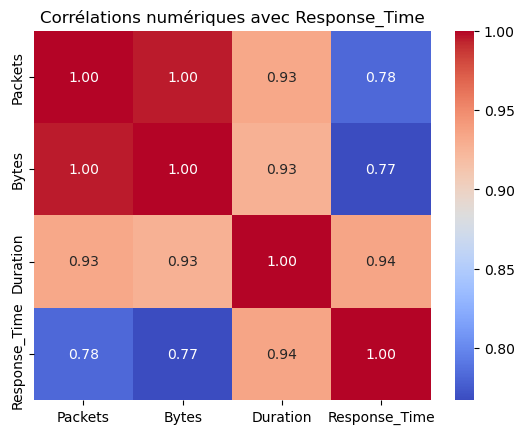

In [6]:
corr = df[["Packets","Bytes","Duration","Response_Time"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations numériques avec Response_Time")
plt.show()

## Étape 3 : Analyse de la variance (ANOVA)

ANOVA F: 9.506 | p-value: 0.0051


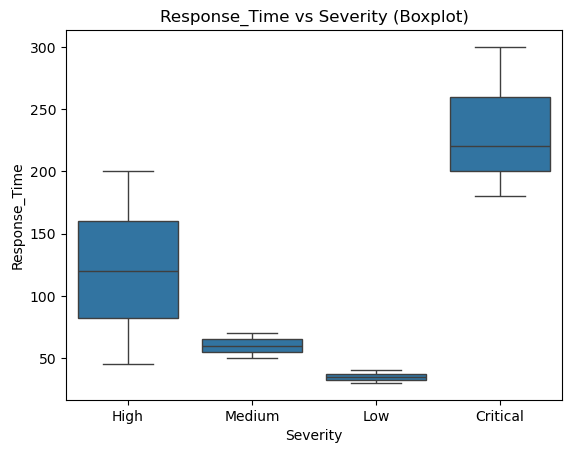

In [7]:
groups = [df.loc[df["Severity"]==lvl, "Response_Time"].values 
          for lvl in df["Severity"].unique()]
F, p = f_oneway(*groups) # f_oneway permet de faire l'ANOVA
print("ANOVA F:", round(F, 3), "| p-value:", round(p, 4))

sns.boxplot(x="Severity", y="Response_Time", data=df)
plt.title("Response_Time vs Severity (Boxplot)")
plt.show()

## Étape 4 : Test du Khi-deux

In [8]:
tab = pd.crosstab(df["Attack_Type"], df["Severity"])
chi2, p, ddl, expected = chi2_contingency(tab)
print("Chi²:", round(chi2, 3), "| p-value:", round(p, 4))
pd.DataFrame(expected, index=tab.index, columns=tab.columns)

Chi²: 24.0 | p-value: 0.0651


Severity,Critical,High,Low,Medium
Attack_Type,,,,
DDoS,0.50,0.50,0.50,0.50
Malware,0.50,0.50,0.50,0.50
Phishing,0.75,0.75,0.75,0.75
PortScan,0.50,0.50,0.50,0.50
Ransomware,0.50,0.50,0.50,0.50
SQLInjection,0.25,0.25,0.25,0.25


## Étape 5 : Préparation des données pour la régression

In [9]:
num_cols = ["Packets","Bytes","Duration"]
cat_cols = ["Attack_Type","Protocol","Source_Country","Target_OS","Severity"]

X = df[num_cols + cat_cols]
y = df["Response_Time"]

preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

## Étape 6 : Régression linéaire

In [10]:
pipe = Pipeline(steps=[
    ("prep", preproc),
    ("reg", LinearRegression())
])

pipe.fit(X, y)
y_pred = pipe.predict(X)

print("R²:", round(r2_score(y, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y, y_pred)), 3))

R²: 1.0
RMSE: 0.0


## Étape 7 : Analyse des coefficients

In [11]:
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(ohe_features)

coef = pd.Series(pipe.named_steps["reg"].coef_, index=all_features).sort_values(ascending=False)

print("Intercept:", round(pipe.named_steps["reg"].intercept_, 3))
print("\nCoefficients :")
print(coef.round(3))

Intercept: 69.144

Coefficients :
Bytes                       138.288
Duration                    107.532
Target_OS_Windows            53.336
Severity_High                39.024
Attack_Type_Ransomware       38.037
Attack_Type_PortScan         30.129
Source_Country_IR            28.467
Target_OS_MacOS              22.656
Protocol_UDP                 18.322
Severity_Low                 15.974
Source_Country_FR            13.085
Severity_Medium               8.752
Source_Country_RU             5.237
Attack_Type_Malware          -4.333
Source_Country_US            -7.451
Protocol_TCP                 -8.754
Source_Country_CN            -9.569
Source_Country_IN           -15.614
Attack_Type_SQLInjection    -15.614
Attack_Type_Phishing        -38.650
Packets                    -164.902
dtype: float64


## Étape 8 : Visualisation des prédictions

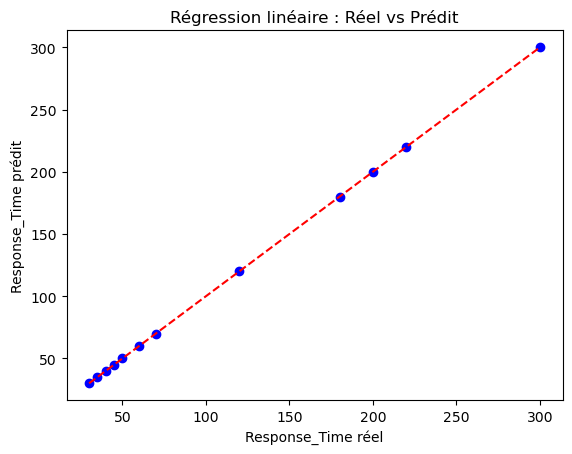

In [12]:
plt.scatter(y, y_pred, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Response_Time réel")
plt.ylabel("Response_Time prédit")
plt.title("Régression linéaire : Réel vs Prédit")
plt.show()

# **Deuxième partie: Travail à faire**

**Contexte du TP**

L’entreprise CyberCorp enregistre dans son SIEM (Security Information and Event Management) toutes les tentatives de connexion à son système d’information (voir fichier `cybersecurity_latency.csv`).
Chaque log contient :

- **user_id** : identifiant utilisateur (user_1, user_2, …)

- **role** : Admin, Employe, Manager, Externe

- **department** : IT, Finance, RH, Production

- **hour** : heure de connexion (0–23h)

- **location** : pays d’origine (Maroc, France, USA, Chine, Russie)

- **device_type** : Desktop, Mobile, Serveur

- **failed_attempts_24h** : nombre d’échecs d’authentification des dernières 24h

- **auth_success** : succès (1) ou échec (0) de l’authentification

- **latency_ms** : latence de la connexion en millisecondes

- **anomaly_score** : score d’anomalie (entre 0 et 1)

Vous devez étudier la variable latency_ms (latence réseau) en fonction des autres caractéristiques, à travers les mesures de dépondances et un modèle de regression linéaire.

Faites le travail selon les étapes ci-après:

## Étape 1 : Chargement et exploration

- Importer les bibliothèques : pandas, numpy, matplotlib, seaborn, sklearn.

- Générer ou charger le dataset fourni.

- Afficher les 10 premières lignes et vérifier les types de variables.

In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

df = pd.read_csv("data/cybersecurity_latency.csv")
df.head(10)

,role,department,hour,location,device_type,failed_attempts_24h,anomaly_score,latency_ms,Serveur_x_failed
0,Employe,RH,15,Maroc,Serveur,4,0.138,278.6,4
1,Externe,Production,1,Russie,Mobile,1,0.326,59.3,0
2,Manager,Finance,5,Chine,Desktop,0,0.406,167.4,0
3,Employe,Production,20,USA,Mobile,3,0.049,85.4,0
4,Employe,Production,11,USA,Mobile,1,0.000,76.6,0
5,Employe,RH,4,USA,Mobile,1,0.393,64.7,0
6,Admin,Production,1,Maroc,Desktop,2,0.365,53.0,0
7,Externe,RH,15,Chine,Serveur,0,0.033,247.0,0
8,Employe,IT,4,Russie,Mobile,5,0.350,59.6,0
9,Manager,IT,14,France,Desktop,3,0.058,79.2,0


In [16]:
df.dtypes

role                    object
department              object
hour                     int64
location                object
device_type             object
failed_attempts_24h      int64
anomaly_score          float64
latency_ms             float64
Serveur_x_failed         int64
dtype: object

## Étape 2 : Analyse exploratoire

- Faire un heatmap des corrélations entre variables numériques (failed_attempts_24h, hour, latency_ms, anomaly_score).

- Faire un boxplot de `latency_ms` selon `location`.

- Faire un test ANOVA pour voir si `latency_ms` varie selon `device_type`.

- Faire un test du Khi-deux pour tester la dépendance entre `role` et `auth_success`.

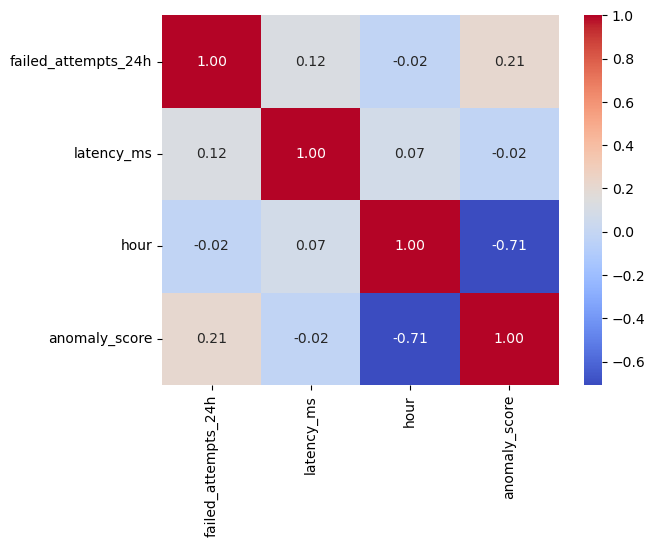

In [18]:
correlations = df[["failed_attempts_24h","latency_ms","hour","anomaly_score"]].corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

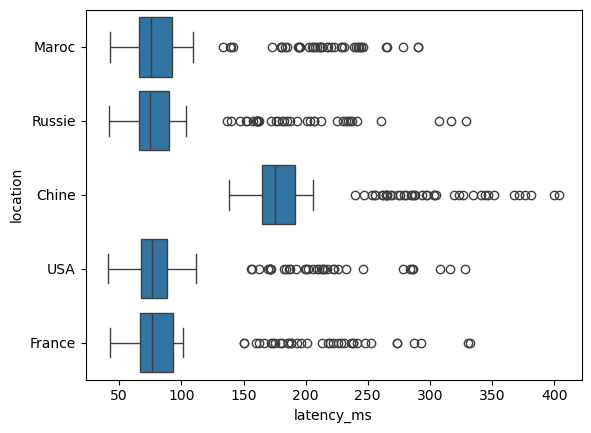

In [20]:
sns.boxplot(x="latency_ms", y="location", data=df)
plt.show()

## Étape 3 : Préparation des données

- Séparer les variables explicatives (X) et la cible (y = `latency_ms`).

- Identifier les colonnes numériques et catégorielles.

- Utiliser un ColumnTransformer avec :

    - **StandardScaler()** pour les variables numériques

    - **OneHotEncoder(drop="first")** pour les variables catégorielles

## Étape 4 : Modèle de régression linéaire

- Construire un pipeline avec :

    - préprocesseur (ColumnTransformer)

    - modèle (LinearRegression)

- Entraîner le modèle et faire les prédictions.

- Calculer les métriques :

    - R² (coefficient de détermination)

    - RMSE (erreur quadratique moyenne)

## Étape 5 : Interprétation

- Afficher les coefficients associés aux variables.

- Identifier :

    - Quelles localisations ou quels types de device augmentent la latence.

    - L’effet des variables quantitatives (failed_attempts_24h, hour) sur la latence.

## Étape 6 : Effet interaction entre deux variables

**Exemple illustratif**: On veut prédire la probabilité d’échec de connexion (failed_attempts) en fonction de :

- `device` (PC, serveur, smartphone),
- `hour` (heure de la journée).

Le modèle:  **Y=β0​+β1​⋅device+β2​⋅hour+ε** suppose que **l’effet du type d’appareil (device) est le même quelle que soit l’heure (hour)**.

Pourtant, l’effet du device à changer selon l’heure, c'est ce qu'on appelle **effet interaction**. Par exemple :

- Les serveurs peuvent avoir plus d’échecs de connexion la nuit (maintenance, scans automatiques).
- Les smartphones peuvent avoir plus d’échecs en journée (mauvais réseaux).

Une interaction entre deux variables signifie que l’effet d’une variable sur la variable cible dépend de la valeur de l’autre variable.

Le modèle avec interaction va capturer cette nuance :  **Y=β0​+β1​⋅device+β2​⋅hour+β3​⋅(device×hour)+ε**

**Question**: Evaluer l'effet interaction entre `devices=="Serveur` et `failed_attempts` sur le modèle de regression